# Optimize dual frame

This document shows you how to ...

In [1]:
%load_ext autoreload
%autoreload 2

## Quantum Circuit

### Define quantum circuit
The circuit can contain some ancilla qubits that you might not want to measure.

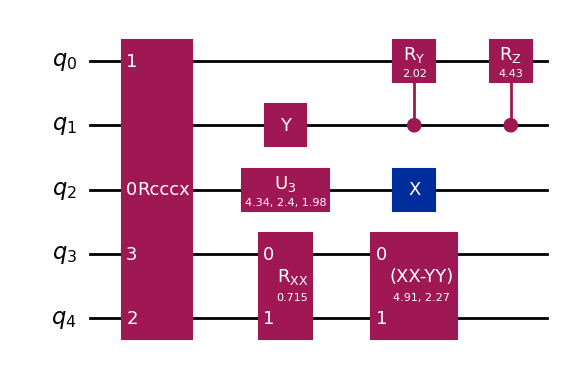

In [2]:
from qiskit.circuit.random import random_circuit

qc = random_circuit(5, 3, measure=False, seed=875)
qc.draw("mpl", style="iqp")

### Define measurement procedure

The `measurement_layout` argument specifies which qubits to measure. It can be seen as a map from virtual to physical qubits indices. In this example, we only want to measure qubits 1 and 3.

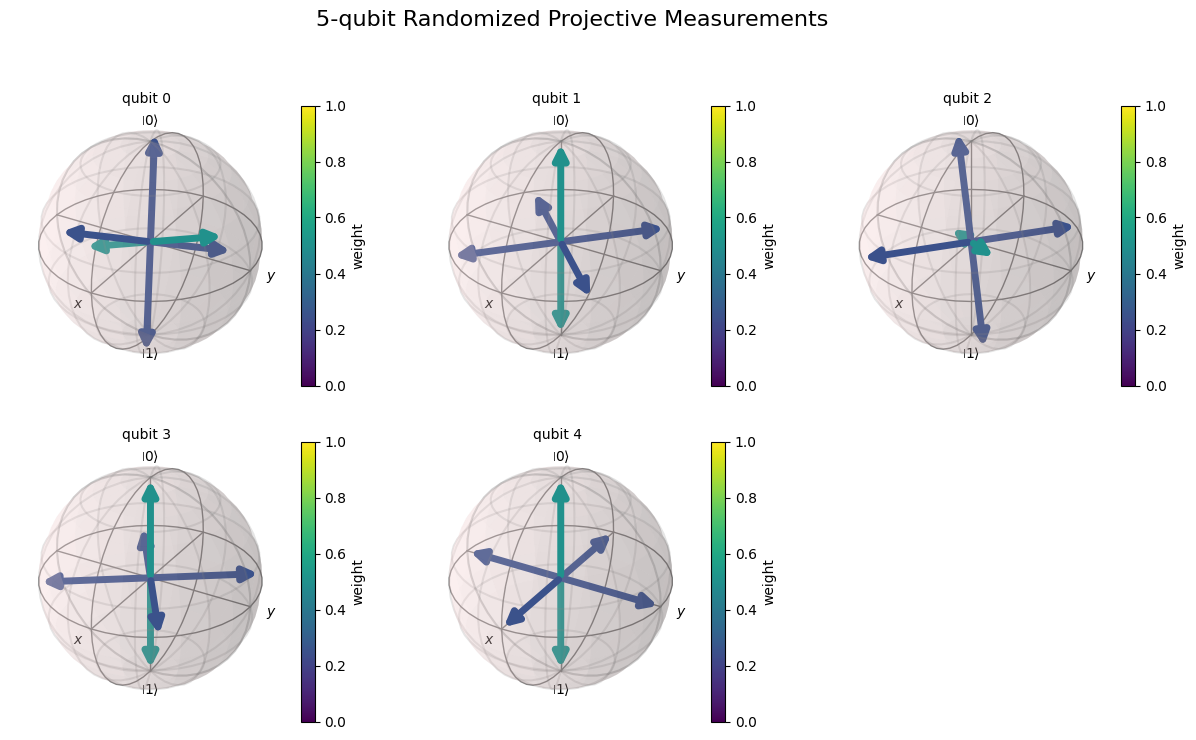

In [3]:
import numpy as np
from numpy.random import default_rng
from povm_toolbox.library import RandomizedProjectiveMeasurements

rng = default_rng(13)

n_qubit = qc.num_qubits

bias = np.array([0.5, 0.25, 0.25])
angles = np.array(
    [
        [2.01757238, -1.85001671, 2.52155716, 0.45636669, 1.17175533, -0.48263278],
        [0.0, 0.0, 1.57079633, -2.35619449, 1.57079633, -0.78539816],
        [1.94493547, -2.39620342, 0.3760775, -2.28966468, 1.53443501, 2.33046898],
        [0.0, 0.0, 1.57079633, 0.6, 1.57079633, 2.17079633],
        [0.0, 0.0, 1.57079633, 0.0, 1.57079633, 1.57079633],
    ]
)

measurement = RandomizedProjectiveMeasurements(n_qubit, bias=bias, angles=angles, seed_rng=rng)
measurement.definition().draw_bloch(
    title=f"{n_qubit}-qubit Randomized Projective Measurements", colorbar=True
)

### Run the job

Initialize `Sampler` and `POVMSampler`. Then run the job.

In [4]:
from povm_toolbox.sampler import POVMSampler
from qiskit.primitives import StatevectorSampler

rng2 = default_rng(26)

sampler = StatevectorSampler(seed=rng2)
povm_sampler = POVMSampler(sampler=sampler)

job = povm_sampler.run([qc], shots=4096, povm=measurement)
pub_result = job.result()[0]

### Define observable

In [5]:
from qiskit.quantum_info import SparsePauliOp

observable = SparsePauliOp(
    ["XIIII", "IIYII", n_qubit * "Y", n_qubit * "Z"], coeffs=[1.3, 1.2, -1, 1.4]
)

### Get the expected value

In [6]:
from povm_toolbox.post_processor import POVMPostProcessor
from qiskit.quantum_info import Statevector

exact_expectation_value = np.real_if_close(Statevector(qc).expectation_value(observable))
print(f"Exact value:     {exact_expectation_value}")

post_processor = POVMPostProcessor(pub_result)

exp_value, std = post_processor.get_single_exp_value_and_std(observable)
print(f"Estimated value: {exp_value}")
print(f"\nEstimated standard deviation of the estimator: {std}")

Exact value:     0.9786732290044553
Estimated value: 1.4188750063207425

Estimated standard deviation of the estimator: 0.4190938784338711


In [7]:
from povm_toolbox.post_processor.ppp_state_marginal import PPPStateMarginal

post_processor = PPPStateMarginal(pub_result)
post_processor.set_marginal_probabilities_dual(state=Statevector(qc))

exp_value, std = post_processor.get_single_exp_value_and_std(observable)
print(f"Estimated value: {exp_value}")
print(f"\nEstimated standard deviation of the estimator: {std}")

Estimated value: 1.0871502953823318

Estimated standard deviation of the estimator: 0.3395552706148222


In [8]:
from povm_toolbox.post_processor.ppp_empirical_frequencies import PPPEmpiricalFrequencies

post_processor = PPPEmpiricalFrequencies(pub_result)
post_processor.set_empirical_frequencies_dual(loc=0)

exp_value, std = post_processor.get_single_exp_value_and_std(observable)
print(f"Estimated value: {exp_value}")
print(f"\nEstimated standard deviation of the estimator: {std}")

Estimated value: 1.0783653352455762

Estimated standard deviation of the estimator: 0.33969484828629726


In [9]:
# post_processor.greedy_exact_scalar_gauge(
#     observable,
#     outcomes=set(
#         [idx for idx in np.ndindex((6,1,6,1,1))
#         ]
#     ),
# )

# exp_value, std = post_processor.get_single_exp_value_and_std(observable)
# print(f"Estimated value: {exp_value}")
# print(f"\nEstimated standard deviation of the estimator: {std}")

/Users/dao/Documents/Internship/povm-toolbox/povm_toolbox/post_processor/dual_optimizer.py:320: LinAlgWarning: Ill-conditioned matrix (rcond=4.04888e-23): result may not be accurate.
  x = solve(hess_matrix, b)


Estimated value: 1.0594495455195683

Estimated standard deviation of the estimator: 0.34304106614400093


In [10]:
# post_processor.greedy_exact_scalar_gauge(
#     observable,
#     outcomes=set(
#         [idx for idx in np.ndindex((2,2,2,2,2))
#         ]
#     ),
# )

# exp_value, std = post_processor.get_single_exp_value_and_std(observable)
# print(f"Estimated value: {exp_value}")
# print(f"\nEstimated standard deviation of the estimator: {std}")

/Users/dao/Documents/Internship/povm-toolbox/povm_toolbox/post_processor/dual_optimizer.py:320: LinAlgWarning: Ill-conditioned matrix (rcond=6.51067e-35): result may not be accurate.
  x = solve(hess_matrix, b)


Estimated value: 1.057020506738599

Estimated standard deviation of the estimator: 0.3483408178067569


In [11]:
# post_processor.greedy_exact_scalar_gauge(
#     observable,
#     outcomes=set(
#         [
#             (5, 1, 0, 0, 1),
#             (5, 1, 0, 1, 0),
#             (5, 1, 0, 1, 2),
#             (5, 2, 0, 1, 0),
#             (5, 2, 0, 0, 1),
#             (2, 1, 0, 1, 0),
#             (5, 2, 0, 1, 2),
#             (5, 1, 0, 2, 1),
#             (2, 1, 0, 1, 2),
#         ]
#     ),
# )

# exp_value, std = post_processor.get_single_exp_value_and_std(observable)
# print(f"Estimated value: {exp_value}")
# print(f"\nEstimated standard deviation of the estimator: {std}")

Estimated value: 1.0559893633095216

Estimated standard deviation of the estimator: 0.3485368768546872


In [ ]:
# post_processor.greedy_optimize_scalar_gauge(observable, outcomes=set(post_processor.gammas.keys()))

# exp_value, std = post_processor.get_single_exp_value_and_std(observable)
# print(f"Estimated value: {exp_value}")
# print(f"\nEstimated standard deviation of the estimator: {std}")